In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import GetGHZCircuitsForModel
from circuits.pqc_circuits import qiskit_PQC_RZRX_unique
from circuits.modify_circuits import append_pqc_to_quantum_circuit

from models.noise_models import BitPhaseFlipNoise
from models.qiskit_models import SimpleQiskitQuantumModel

from simulator.simulate import get_ideal_data, get_ideal_data_superpos

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 25

ideal_sim = AerSimulator(device=aer_device)

pqc_arch = qiskit_PQC_RZRX_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimpleQiskitQuantumModel(
    num_params=NUM_QUBITS*2, simulator=ideal_sim, num_shots=NUM_SHOTS, pqc_arch_func=pqc_arch
)

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
)



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_superpos(NUM_QUBITS, NUM_SHOTS, num_vals=int(10000), device=aer_device)
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:16<00:00, 619.67it/s]

32


In [9]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for params, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=ghz_circuit_gen.get_noisy_model_circuit_params(params))
        # print(ideal)
        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)
        
        loss = loss_fn(ideal, measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.pqc_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    param_arr = np.array(param_list).transpose()
    print(param_arr)    
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 10000/10000 [01:36<00:00, 103.21it/s, Loss: 1198.0]   


Loss: 6672.8242, Params: Parameter containing:
tensor([13.6866, 13.5908, 13.7785, 11.8371, 13.4856, 13.1918, 12.0296, 12.5291,
        13.0931, 12.9229], requires_grad=True)
[[15.127985  15.127833  15.127682  ... 13.686901  13.686764  13.686626 ]
 [15.022005  15.021854  15.021704  ... 13.591027  13.590891  13.5907545]
 [15.229496  15.229343  15.229191  ... 13.778734  13.778596  13.778458 ]
 ...
 [13.848517  13.848379  13.848241  ... 12.529313  12.529187  12.529061 ]
 [14.471984  14.471839  14.471694  ... 13.093333  13.093203  13.093072 ]
 [14.283813  14.28367   14.283527  ... 12.923134  12.923004  12.922874 ]]
Starting Epoch 2


100%|██████████| 10000/10000 [01:38<00:00, 101.47it/s, Loss: 1084.1875]


Loss: 4342.1799, Params: Parameter containing:
tensor([12.3825, 12.2958, 12.4656, 10.7092, 12.2007, 11.9348, 10.8833, 11.3353,
        11.8455, 11.6915], requires_grad=True)
[[15.127985  15.127833  15.127682  ... 12.38277   12.382646  12.382522 ]
 [15.022005  15.021854  15.021704  ... 12.296029  12.295906  12.295783 ]
 [15.229496  15.229343  15.229191  ... 12.465853  12.465728  12.465603 ]
 ...
 [13.848517  13.848379  13.848241  ... 11.335522  11.335408  11.335295 ]
 [14.471984  14.471839  14.471694  ... 11.845752  11.8456335 11.845515 ]
 [14.283813  14.28367   14.283527  ... 11.691761  11.691644  11.691526 ]]
Starting Epoch 3


100%|██████████| 10000/10000 [01:44<00:00, 95.28it/s, Loss: 17563.25]  


Loss: 9149.2242, Params: Parameter containing:
tensor([11.2026, 11.1242, 11.2778,  9.6888, 11.0382, 10.7976,  9.8463, 10.2552,
        10.7168, 10.5775], requires_grad=True)
[[15.127985 15.127833 15.127682 ... 11.202823 11.20271  11.202598]
 [15.022005 15.021854 15.021704 ... 11.124391 11.124279 11.124167]
 [15.229496 15.229343 15.229191 ... 11.277979 11.277866 11.277754]
 ...
 [13.848517 13.848379 13.848241 ... 10.255375 10.255272 10.255169]
 [14.471984 14.471839 14.471694 ... 10.716987 10.716879 10.716771]
 [14.283813 14.28367  14.283527 ... 10.577731 10.577625 10.577519]]
Starting Epoch 4


100%|██████████| 10000/10000 [01:51<00:00, 89.76it/s, Loss: 23166.375] 


Loss: 12757.5969, Params: Parameter containing:
tensor([10.1351, 10.0642, 10.2032,  8.7656,  9.9864,  9.7687,  8.9080,  9.2780,
         9.6957,  9.5695], requires_grad=True)
[[15.127985 15.127833 15.127682 ... 10.135336 10.135235 10.135134]
 [15.022005 15.021854 15.021704 ... 10.064373 10.064272 10.064171]
 [15.229496 15.229343 15.229191 ... 10.203414 10.203312 10.20321 ]
 ...
 [13.848517 13.848379 13.848241 ...  9.27815   9.278057  9.277965]
 [14.471984 14.471839 14.471694 ...  9.695889  9.695792  9.695695]
 [14.283813 14.28367  14.283527 ...  9.569727  9.569632  9.569536]]
Starting Epoch 5


100%|██████████| 10000/10000 [01:53<00:00, 88.45it/s, Loss: 10319.5625]


Loss: 12237.3721, Params: Parameter containing:
tensor([9.1694, 9.1052, 9.2310, 7.9304, 9.0348, 8.8380, 8.0593, 8.3940, 8.7719,
        8.6578], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  9.169629   9.169538   9.169446 ]
 [15.022005  15.021854  15.021704  ...  9.105361   9.105269   9.105178 ]
 [15.229496  15.229343  15.229191  ...  9.231193   9.2311     9.231008 ]
 ...
 [13.848517  13.848379  13.848241  ...  8.394157   8.3940735  8.39399  ]
 [14.471984  14.471839  14.471694  ...  8.772034   8.771946   8.771858 ]
 [14.283813  14.28367   14.283527  ...  8.657978   8.657891   8.6578045]]
Starting Epoch 6


100%|██████████| 10000/10000 [02:10<00:00, 76.42it/s, Loss: 9613.875] 


Loss: 9598.7540, Params: Parameter containing:
tensor([8.2958, 8.2375, 8.3514, 7.1747, 8.1740, 7.9959, 7.2914, 7.5941, 7.9360,
        7.8328], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  8.2959385  8.2958555  8.295773 ]
 [15.022005  15.021854  15.021704  ...  8.2376995  8.2376175  8.237535 ]
 [15.229496  15.229343  15.229191  ...  8.351557   8.351473   8.351389 ]
 ...
 [13.848517  13.848379  13.848241  ...  7.5942984  7.5942225  7.5941467]
 [14.471984  14.471839  14.471694  ...  7.936187   7.936107   7.9360275]
 [14.283813  14.28367   14.283527  ...  7.832978   7.8328996  7.8328214]]
Starting Epoch 7


100%|██████████| 10000/10000 [01:40<00:00, 99.13it/s, Loss: 3296.875]  


Loss: 6916.5697, Params: Parameter containing:
tensor([7.5053, 7.4527, 7.5557, 6.4911, 7.3951, 7.2340, 6.5966, 6.8706, 7.1798,
        7.0865], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  7.5054445  7.505369   7.505294 ]
 [15.022005  15.021854  15.021704  ...  7.452857   7.452782   7.4527073]
 [15.229496  15.229343  15.229191  ...  7.555811   7.555735   7.5556593]
 ...
 [13.848517  13.848379  13.848241  ...  6.8706927  6.870624   6.8705554]
 [14.471984  14.471839  14.471694  ...  7.1799917  7.1799197  7.1798477]
 [14.283813  14.28367   14.283527  ...  7.0866365  7.0865655  7.0864944]]
Starting Epoch 8


100%|██████████| 10000/10000 [01:35<00:00, 104.21it/s, Loss: 2829.625] 


Loss: 4488.8613, Params: Parameter containing:
tensor([6.7901, 6.7426, 6.8357, 5.8726, 6.6904, 6.5447, 5.9681, 6.2159, 6.4957,
        6.4112], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  6.790279   6.7902107  6.7901425]
 [15.022005  15.021854  15.021704  ...  6.7427154  6.7426476  6.74258  ]
 [15.229496  15.229343  15.229191  ...  6.8358345  6.835766   6.835697 ]
 ...
 [13.848517  13.848379  13.848241  ...  6.215991   6.2159286  6.215866 ]
 [14.471984  14.471839  14.471694  ...  6.4958224  6.4957576  6.4956927]
 [14.283813  14.28367   14.283527  ...  6.4113674  6.411303   6.4112387]]
Starting Epoch 9


100%|██████████| 10000/10000 [01:37<00:00, 102.26it/s, Loss: 2651.4375]


Loss: 2225.3747, Params: Parameter containing:
tensor([6.1432, 6.1001, 6.1844, 5.3130, 6.0530, 5.9211, 5.3994, 5.6236, 5.8767,
        5.8004], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  6.143292   6.1432304  6.143169 ]
 [15.022005  15.021854  15.021704  ...  6.100258   6.100197   6.100136 ]
 [15.229496  15.229343  15.229191  ...  6.184509   6.184447   6.184385 ]
 ...
 [13.848517  13.848379  13.848241  ...  5.623735   5.6236787  5.6236224]
 [14.471984  14.471839  14.471694  ...  5.876862   5.8768034  5.8767447]
 [14.283813  14.28367   14.283527  ...  5.800474   5.800416   5.800358 ]]
Starting Epoch 10


100%|██████████| 10000/10000 [01:38<00:00, 101.94it/s, Loss: 4413.9375]


Loss: 3277.3477, Params: Parameter containing:
tensor([5.5578, 5.5189, 5.5951, 4.8068, 5.4762, 5.3568, 4.8849, 5.0878, 5.3168,
        5.2477], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  5.5579123  5.5578566  5.557801 ]
 [15.022005  15.021854  15.021704  ...  5.5189953  5.51894    5.5188847]
 [15.229496  15.229343  15.229191  ...  5.5951705  5.5951147  5.595059 ]
 ...
 [13.848517  13.848379  13.848241  ...  5.087875   5.087824   5.087773 ]
 [14.471984  14.471839  14.471694  ...  5.3168902  5.316837   5.3167834]
 [14.283813  14.28367   14.283527  ...  5.2477746  5.247722   5.2476697]]
Starting Epoch 11


100%|██████████| 10000/10000 [01:41<00:00, 98.91it/s, Loss: 9644.375]  


Loss: 7083.0990, Params: Parameter containing:
tensor([5.0282, 4.9930, 5.0620, 4.3488, 4.9544, 4.8464, 4.4195, 4.6030, 4.8102,
        4.7476], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  5.028307   5.0282564  5.028206 ]
 [15.022005  15.021854  15.021704  ...  4.993118   4.9930677  4.9930177]
 [15.229496  15.229343  15.229191  ...  5.062062   5.0620112  5.0619607]
 ...
 [13.848517  13.848379  13.848241  ...  4.6030564  4.60301    4.602964 ]
 [14.471984  14.471839  14.471694  ...  4.810296   4.810248   4.8101997]
 [14.283813  14.28367   14.283527  ...  4.74773    4.747682   4.7476344]]
Starting Epoch 12


100%|██████████| 10000/10000 [01:40<00:00, 99.42it/s, Loss: 10669.75]  


Loss: 9949.2086, Params: Parameter containing:
tensor([4.5491, 4.5173, 4.5796, 3.9344, 4.4823, 4.3847, 3.9984, 4.1643, 4.3518,
        4.2953], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  4.5491667  4.549121   4.549075 ]
 [15.022005  15.021854  15.021704  ...  4.517351   4.517306   4.5172606]
 [15.229496  15.229343  15.229191  ...  4.5797377  4.579692   4.579646 ]
 ...
 [13.848517  13.848379  13.848241  ...  4.164427   4.1643853  4.164344 ]
 [14.471984  14.471839  14.471694  ...  4.351911   4.3518677  4.3518243]
 [14.283813  14.28367   14.283527  ...  4.295355   4.295312   4.295269 ]]
Starting Epoch 13


100%|██████████| 10000/10000 [01:39<00:00, 100.14it/s, Loss: 14989.9375]


Loss: 12006.0549, Params: Parameter containing:
tensor([4.1156, 4.0868, 4.1433, 3.5595, 4.0552, 3.9669, 3.6174, 3.7676, 3.9372,
        3.8860], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  4.1157017  4.1156607  4.1156197]
 [15.022005  15.021854  15.021704  ...  4.086915   4.086874   4.086833 ]
 [15.229496  15.229343  15.229191  ...  4.1433682  4.1433268  4.1432853]
 ...
 [13.848517  13.848379  13.848241  ...  3.767667   3.7676294  3.7675917]
 [14.471984  14.471839  14.471694  ...  3.937269   3.9372296  3.9371903]
 [14.283813  14.28367   14.283527  ...  3.886081   3.886042   3.8860033]]
Starting Epoch 14


100%|██████████| 10000/10000 [01:39<00:00, 100.25it/s, Loss: 11955.5625]


Loss: 13736.9539, Params: Parameter containing:
tensor([3.7235, 3.6974, 3.7485, 3.2203, 3.6688, 3.5889, 3.2727, 3.4086, 3.5620,
        3.5157], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  3.723572   3.7235348  3.7234976]
 [15.022005  15.021854  15.021704  ...  3.6974945  3.6974576  3.6974206]
 [15.229496  15.229343  15.229191  ...  3.7485535  3.748516   3.7484787]
 ...
 [13.848517  13.848379  13.848241  ...  3.4086657  3.4086316  3.4085975]
 [14.471984  14.471839  14.471694  ...  3.5621016  3.5620658  3.56203  ]
 [14.283813  14.28367   14.283527  ...  3.5157883  3.515753   3.5157177]]
Starting Epoch 15


100%|██████████| 10000/10000 [01:39<00:00, 100.50it/s, Loss: 8889.8125]


Loss: 14176.6569, Params: Parameter containing:
tensor([3.3687, 3.3451, 3.3913, 2.9135, 3.3192, 3.2469, 2.9609, 3.0838, 3.2226,
        3.1807], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  3.3687608  3.3687272  3.3686936]
 [15.022005  15.021854  15.021704  ...  3.3451629  3.3451295  3.345096 ]
 [15.229496  15.229343  15.229191  ...  3.3913684  3.3913345  3.3913007]
 ...
 [13.848517  13.848379  13.848241  ...  3.083852   3.083821   3.08379  ]
 [14.471984  14.471839  14.471694  ...  3.222686   3.2226539  3.2226217]
 [14.283813  14.28367   14.283527  ...  3.1807795  3.1807475  3.1807156]]
Starting Epoch 16


100%|██████████| 10000/10000 [01:39<00:00, 100.36it/s, Loss: 17565.375]


Loss: 13431.7065, Params: Parameter containing:
tensor([3.0477, 3.0264, 3.0682, 2.6359, 3.0030, 2.9375, 2.6787, 2.7900, 2.9155,
        2.8777], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  3.0477858  3.0477552  3.0477247]
 [15.022005  15.021854  15.021704  ...  3.026436   3.0264058  3.0263755]
 [15.229496  15.229343  15.229191  ...  3.0682344  3.0682037  3.068173 ]
 ...
 [13.848517  13.848379  13.848241  ...  2.790023   2.7899952  2.7899673]
 [14.471984  14.471839  14.471694  ...  2.915602   2.915573   2.9155438]
 [14.283813  14.28367   14.283527  ...  2.8777103  2.8776815  2.8776526]]
Starting Epoch 17


100%|██████████| 10000/10000 [01:39<00:00, 100.46it/s, Loss: 14728.125]


Loss: 12352.6515, Params: Parameter containing:
tensor([2.7573, 2.7380, 2.7758, 2.3847, 2.7168, 2.6576, 2.4235, 2.5241, 2.6378,
        2.6034], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  2.7573743  2.7573466  2.757319 ]
 [15.022005  15.021854  15.021704  ...  2.7380638  2.7380364  2.738009 ]
 [15.229496  15.229343  15.229191  ...  2.7758617  2.7758338  2.775806 ]
 ...
 [13.848517  13.848379  13.848241  ...  2.5241795  2.5241542  2.524129 ]
 [14.471984  14.471839  14.471694  ...  2.637803   2.6377766  2.6377501]
 [14.283813  14.28367   14.283527  ...  2.6034973  2.6034713  2.6034453]]
Starting Epoch 18


100%|██████████| 10000/10000 [01:40<00:00, 99.98it/s, Loss: 14369.25]  


Loss: 11399.9337, Params: Parameter containing:
tensor([2.4946, 2.4771, 2.5113, 2.1575, 2.4580, 2.4044, 2.1926, 2.2836, 2.3864,
        2.3554], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  2.494636   2.494611   2.494586 ]
 [15.022005  15.021854  15.021704  ...  2.4771678  2.477143   2.4771183]
 [15.229496  15.229343  15.229191  ...  2.5113552  2.5113301  2.511305 ]
 ...
 [13.848517  13.848379  13.848241  ...  2.2836635  2.2836406  2.2836177]
 [14.471984  14.471839  14.471694  ...  2.3864598  2.386436   2.3864121]
 [14.283813  14.28367   14.283527  ...  2.3554358  2.3554122  2.3553886]]
Starting Epoch 19


100%|██████████| 10000/10000 [01:39<00:00, 100.07it/s, Loss: 10382.125]


Loss: 10604.5655, Params: Parameter containing:
tensor([2.2569, 2.2411, 2.2720, 1.9519, 2.2237, 2.1753, 1.9837, 2.0660, 2.1590,
        2.1309], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  2.2569356  2.256913   2.2568903]
 [15.022005  15.021854  15.021704  ...  2.2411304  2.241108   2.2410855]
 [15.229496  15.229343  15.229191  ...  2.2720628  2.2720401  2.2720175]
 ...
 [13.848517  13.848379  13.848241  ...  2.0660605  2.0660398  2.066019 ]
 [14.471984  14.471839  14.471694  ...  2.1590598  2.159038   2.1590164]
 [14.283813  14.28367   14.283527  ...  2.1309671  2.1309457  2.1309245]]
Starting Epoch 20


100%|██████████| 10000/10000 [01:39<00:00, 100.21it/s, Loss: 10311.625]


Loss: 9918.9680, Params: Parameter containing:
tensor([2.0418, 2.0275, 2.0555, 1.7659, 2.0118, 1.9680, 1.7946, 1.8692, 1.9533,
        1.9279], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  2.0418828  2.0418622  2.0418417]
 [15.022005  15.021854  15.021704  ...  2.0275853  2.027565   2.0275447]
 [15.229496  15.229343  15.229191  ...  2.0555766  2.055556   2.0555356]
 ...
 [13.848517  13.848379  13.848241  ...  1.8692025  1.8691838  1.8691651]
 [14.471984  14.471839  14.471694  ...  1.9533473  1.9533278  1.9533082]
 [14.283813  14.28367   14.283527  ...  1.9279492  1.9279299  1.9279106]]
Starting Epoch 21


100%|██████████| 10000/10000 [01:39<00:00, 100.64it/s, Loss: 7576.9375]


Loss: 9326.6830, Params: Parameter containing:
tensor([1.8473, 1.8344, 1.8597, 1.5977, 1.8202, 1.7805, 1.6236, 1.6911, 1.7672,
        1.7442], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  1.8473283  1.8473098  1.8472914]
 [15.022005  15.021854  15.021704  ...  1.8343894  1.8343711  1.8343527]
 [15.229496  15.229343  15.229191  ...  1.8597232  1.8597046  1.859686 ]
 ...
 [13.848517  13.848379  13.848241  ...  1.6910949  1.691078   1.691061 ]
 [14.471984  14.471839  14.471694  ...  1.7672142  1.7671965  1.7671789]
 [14.283813  14.28367   14.283527  ...  1.7442344  1.7442169  1.7441994]]
Starting Epoch 22


100%|██████████| 10000/10000 [01:38<00:00, 101.01it/s, Loss: 8867.375] 


Loss: 8789.5357, Params: Parameter containing:
tensor([1.6713, 1.6596, 1.6825, 1.4454, 1.6467, 1.6108, 1.4689, 1.5299, 1.5988,
        1.5780], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  1.6713     1.6712834  1.6712667]
 [15.022005  15.021854  15.021704  ...  1.6595926  1.659576   1.6595595]
 [15.229496  15.229343  15.229191  ...  1.6825161  1.6824993  1.6824825]
 ...
 [13.848517  13.848379  13.848241  ...  1.5299481  1.5299327  1.5299174]
 [14.471984  14.471839  14.471694  ...  1.598828   1.598812   1.598796 ]
 [14.283813  14.28367   14.283527  ...  1.5780344  1.5780185  1.5780027]]
Starting Epoch 23


100%|██████████| 10000/10000 [01:40<00:00, 99.96it/s, Loss: 5576.0]    


Loss: 8313.0190, Params: Parameter containing:
tensor([1.5120, 1.5014, 1.5222, 1.3077, 1.4898, 1.4574, 1.3290, 1.3841, 1.4464,
        1.4277], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  1.512056   1.5120409  1.5120257]
 [15.022005  15.021854  15.021704  ...  1.5014639  1.5014489  1.5014338]
 [15.229496  15.229343  15.229191  ...  1.5222006  1.5221853  1.5221701]
 ...
 [13.848517  13.848379  13.848241  ...  1.3841732  1.3841593  1.3841455]
 [14.471984  14.471839  14.471694  ...  1.4464753  1.4464607  1.4464462]
 [14.283813  14.28367   14.283527  ...  1.4276792  1.4276649  1.4276506]]
Starting Epoch 24


100%|██████████| 10000/10000 [01:40<00:00, 99.39it/s, Loss: 3459.6875] 


Loss: 7876.8730, Params: Parameter containing:
tensor([1.3680, 1.3584, 1.3771, 1.1831, 1.3479, 1.3185, 1.2023, 1.2523, 1.3086,
        1.2916], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  1.3679796  1.3679659  1.3679522]
 [15.022005  15.021854  15.021704  ...  1.3583972  1.3583837  1.3583701]
 [15.229496  15.229343  15.229191  ...  1.3771536  1.3771398  1.377126 ]
 ...
 [13.848517  13.848379  13.848241  ...  1.2522842  1.2522717  1.2522591]
 [14.471984  14.471839  14.471694  ...  1.3086587  1.3086456  1.3086325]
 [14.283813  14.28367   14.283527  ...  1.2916298  1.2916169  1.291604 ]]
Starting Epoch 25


100%|██████████| 10000/10000 [01:38<00:00, 101.59it/s, Loss: 8691.0625]


Loss: 7482.9661, Params: Parameter containing:
tensor([1.2376, 1.2289, 1.2459, 1.0704, 1.2194, 1.1929, 1.0878, 1.1329, 1.1839,
        1.1685], requires_grad=True)
[[15.127985  15.127833  15.127682  ...  1.2376323  1.2376199  1.2376075]
 [15.022005  15.021854  15.021704  ...  1.2289602  1.2289479  1.2289356]
 [15.229496  15.229343  15.229191  ...  1.24593    1.2459174  1.2459049]
 ...
 [13.848517  13.848379  13.848241  ...  1.1329612  1.1329498  1.1329385]
 [14.471984  14.471839  14.471694  ...  1.1839517  1.1839399  1.1839281]
 [14.283813  14.28367   14.283527  ...  1.1685681  1.1685565  1.1685448]]


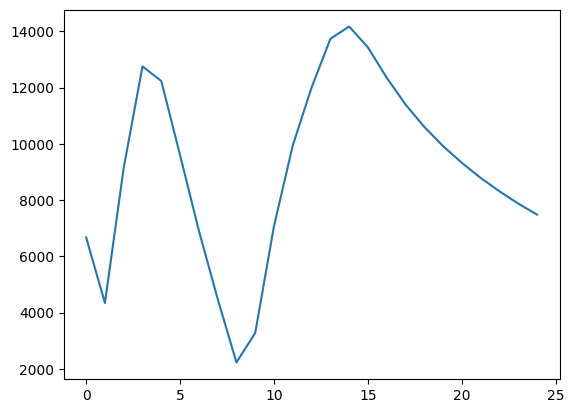

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[15.127985  15.127833  15.127682  ...  1.2376323  1.2376199  1.2376075]
 [15.022005  15.021854  15.021704  ...  1.2289602  1.2289479  1.2289356]
 [15.229496  15.229343  15.229191  ...  1.24593    1.2459174  1.2459049]
 ...
 [13.848517  13.848379  13.848241  ...  1.1329612  1.1329498  1.1329385]
 [14.471984  14.471839  14.471694  ...  1.1839517  1.1839399  1.1839281]
 [14.283813  14.28367   14.283527  ...  1.1685681  1.1685565  1.1685448]]


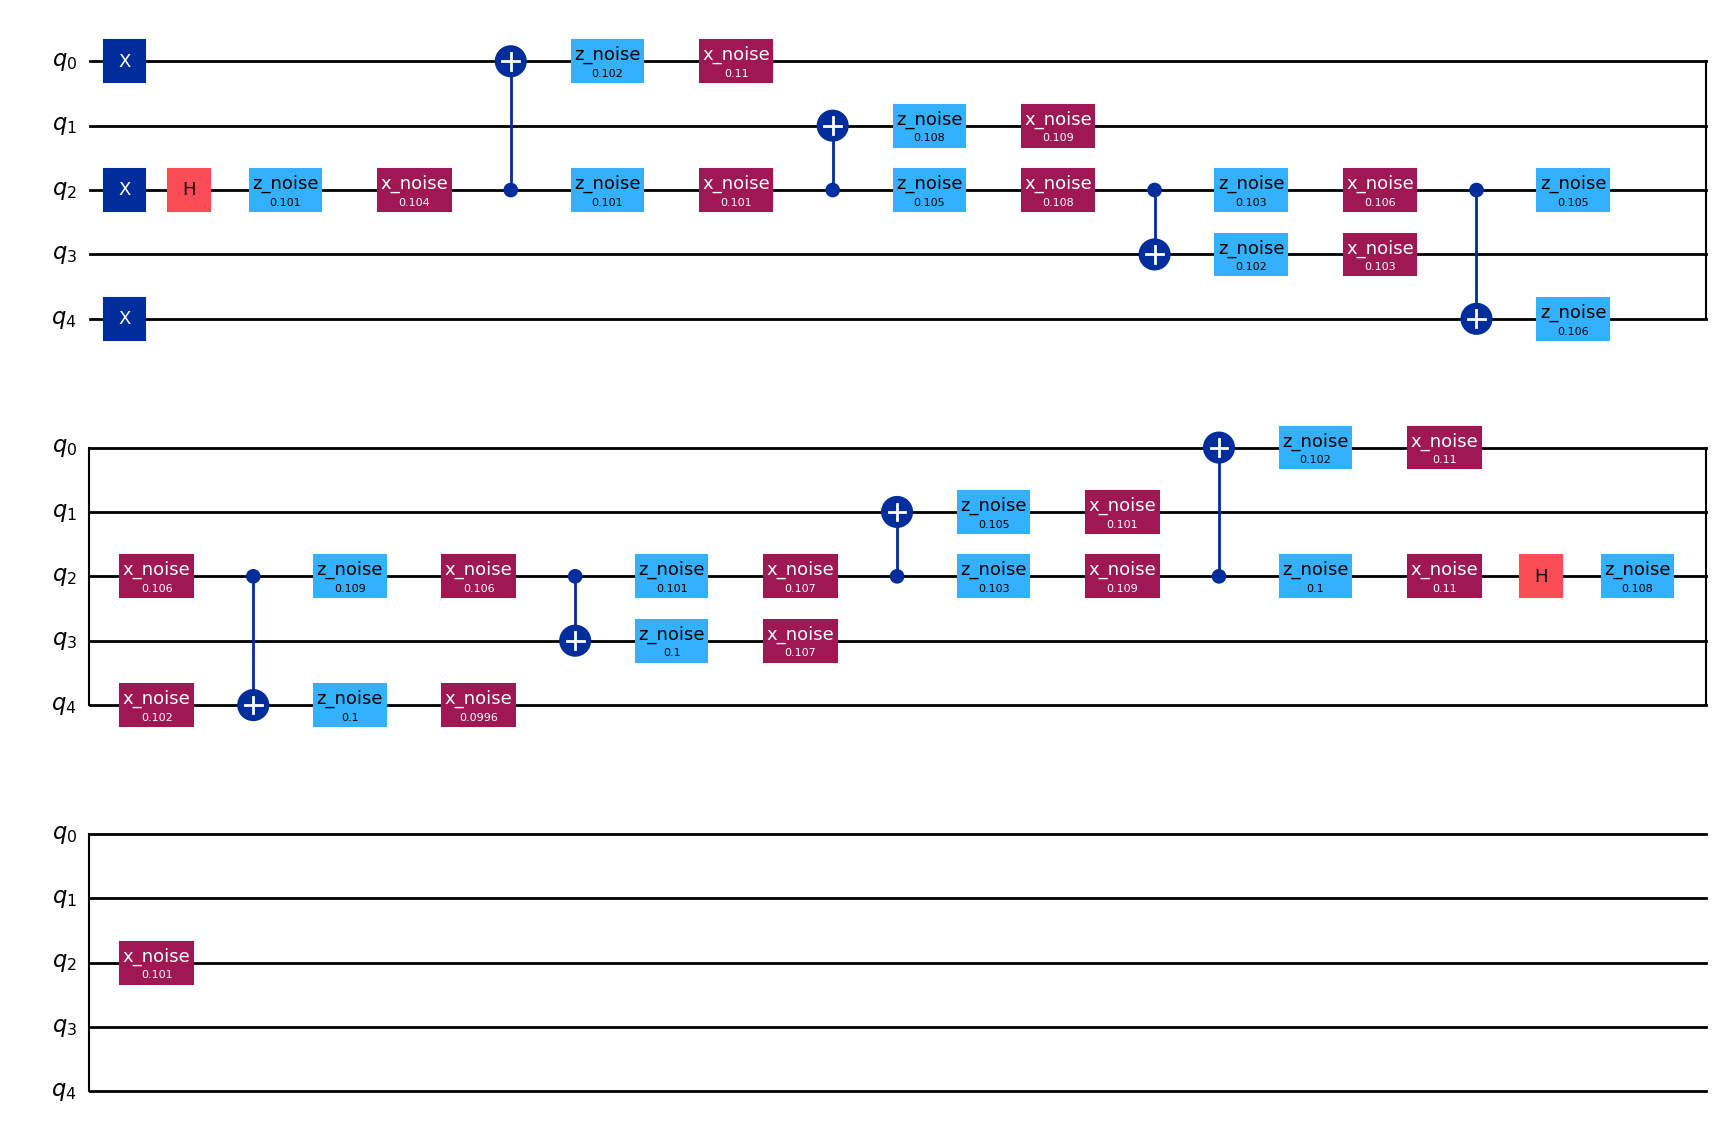

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

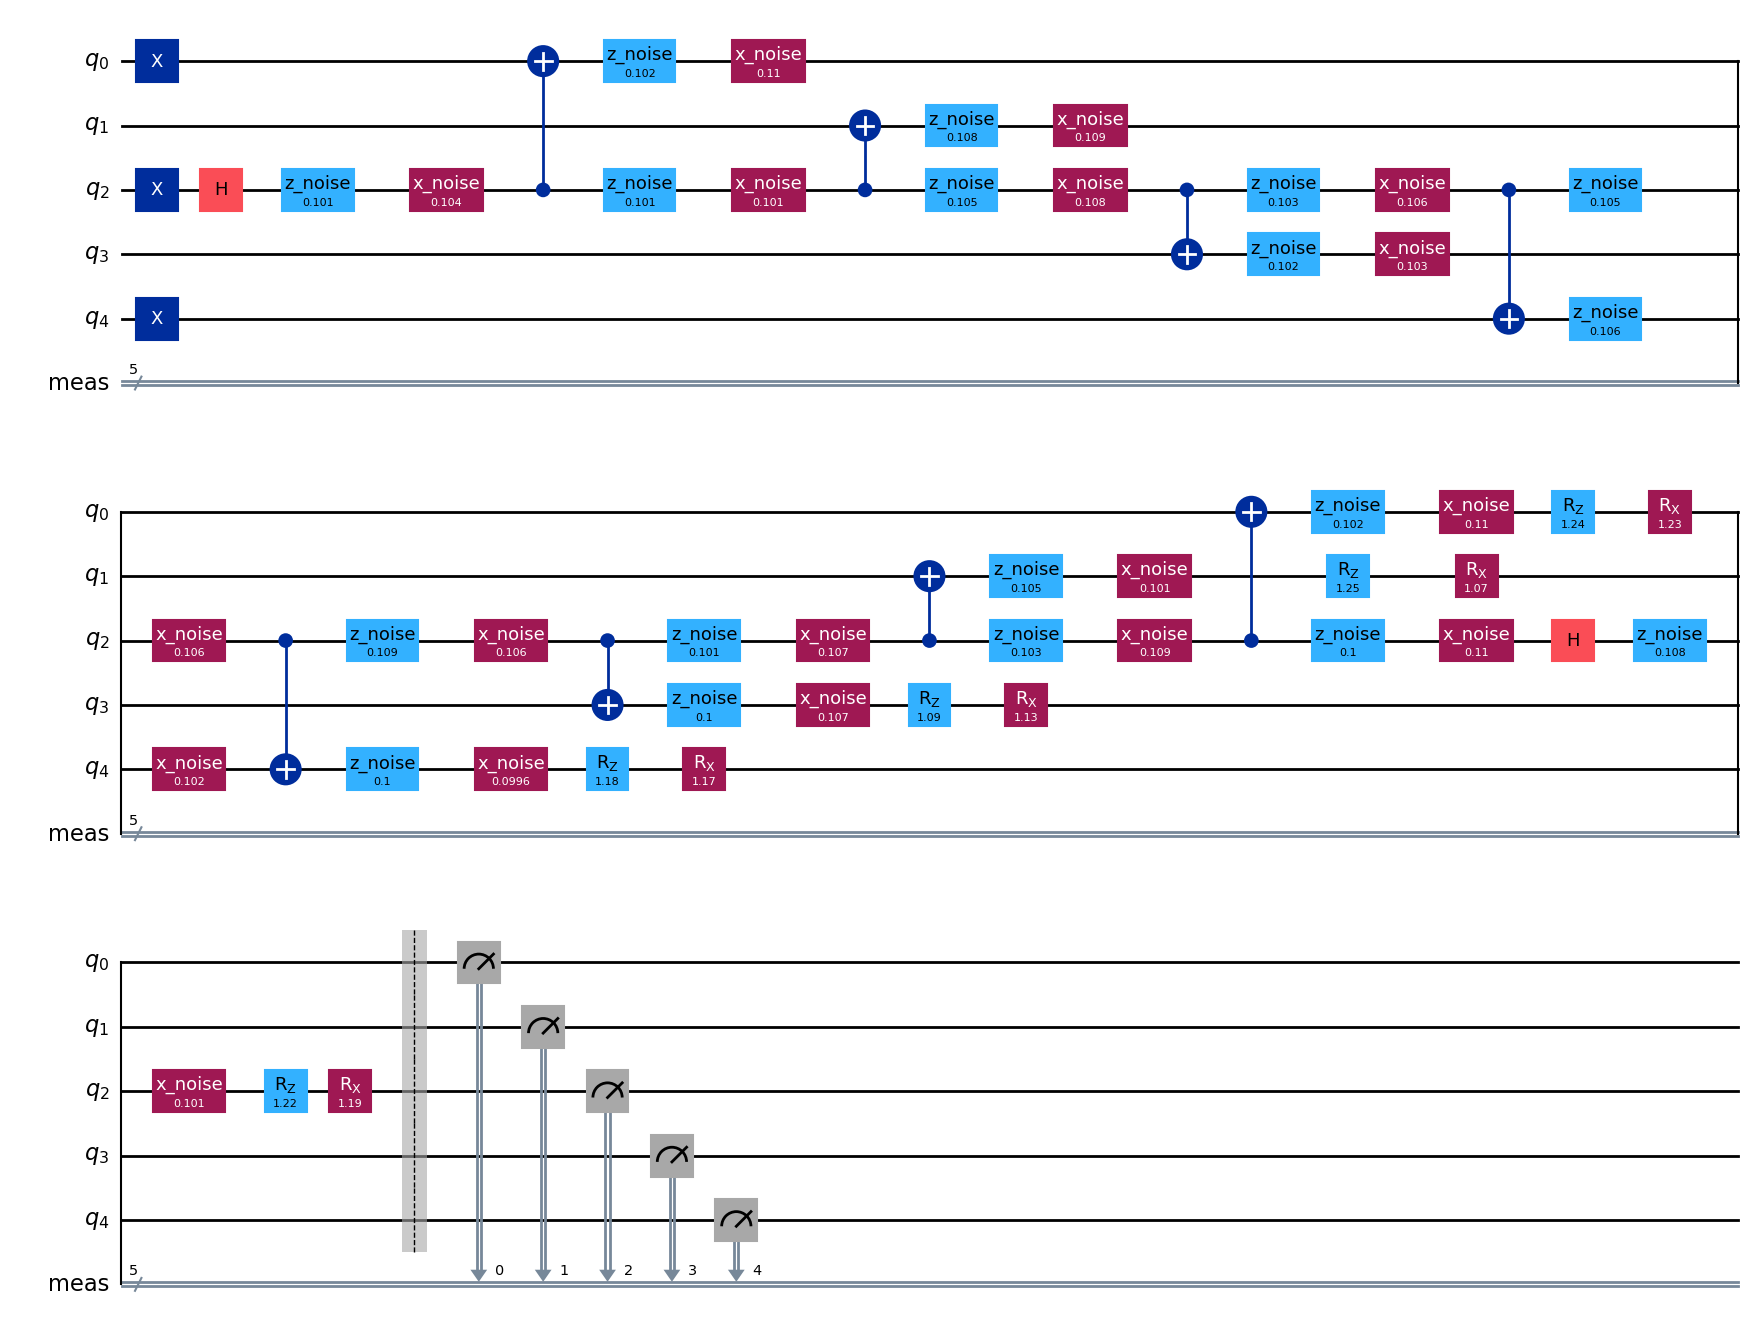

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.pqc_params, pqc_arch)
noisy_model_circ_pqc.draw('mpl')

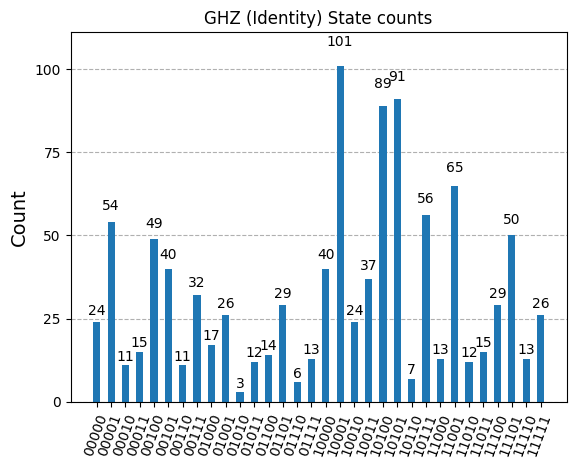

In [14]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

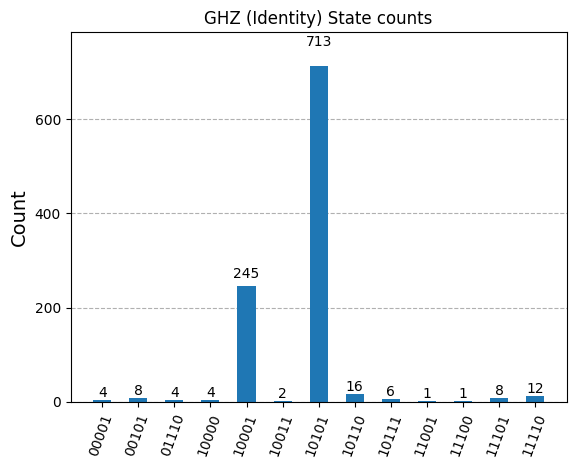

In [15]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')